In [6]:
import scipy as sp
import scipy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tqdm

from sys import getsizeof


# The Idea: SIDM

given cross-section defines a radius at which it transitions from NFW to thermalized region. This means I can match at this surface. We can be approximate

relevant references: https://academic.oup.com/mnras/article/465/1/76/2417479

https://galaxiesbook.org/chapters/II-01.-Flattened-Mass-Distributions.html

https://academic.oup.com/mnras/article/392/4/1503/965081

## Can I solve the Poisson Equation well enough?

I am trying to solve:

$$\partial^2 \Phi = 4 \pi G \rho $$

After a fourier transform:

$$- k^2 \tilde{\Phi} = 4\pi G \tilde{\rho}$$

And so we need to:

$$\Phi = -4\pi G\; \times \;\mathcal{F} \left(\frac{\tilde{\rho}}{k^2}\right)$$

But what does this dimensionally mean?

$$ \tilde{\rho} = \int dx dy dz \rho(\vec{x}) \exp(i \vec{k} \vec{x}) $$

And so:

$$ \int dk_x dk_y dk_z \exp(i \vec{k} \vec{x}) \frac{\int \rho(\vec{x'}) \exp(i \vec{k} \vec{x'}) dx' dy' dz'}{ k^2}$$

Imagine that $\rho(x) = \delta(x)$

In [96]:
NN = 256
mid = NN//2
print(f"{mid=}")

boundary=10.0

x = np.linspace(-boundary,boundary,NN)
step = (x[1]-x[0])

rs = np.sqrt(x**2 + step**2 + step**2)


kmodes = np.fft.fftfreq(NN,d=step)

rho0 = 1.0/step**3


print(f"{step=}")


xx,yy,zz = np.meshgrid(x,x,x)
kx,ky,kz = np.meshgrid(kmodes,kmodes,kmodes)

ksq = kx**2+ky**2+kz**2


rho = 0.0*kx

rho[mid,mid,mid]      =rho0/8.0
rho[mid-1,mid,mid]    =rho0/8.0
rho[mid,mid-1,mid]    =rho0/8.0
rho[mid,mid,mid-1]    =rho0/8.0
rho[mid-1,mid-1,mid]  =rho0/8.0
rho[mid,mid-1,mid-1]  =rho0/8.0
rho[mid-1,mid,mid-1]  =rho0/8.0
rho[mid-1,mid-1,mid-1]=rho0/8.0
"""
rho[mid,mid,mid]      = rho0
"""

mid=128
step=0.07843137254901933


'\nrho[mid,mid,mid]      = rho0\n'

100%|██████████| 11/11 [00:09<00:00,  1.16it/s]


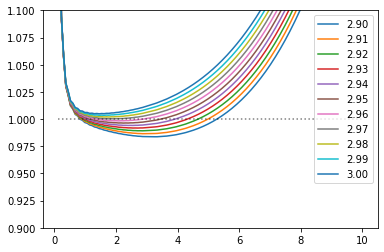

In [98]:

for factor in tqdm.tqdm(np.linspace(2.9,3.0,11)):
    eps = kmodes[1]/(factor)
    ksq[0,0,0] = eps**2
    pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(4.0*np.pi**2)
    plt.plot(rs[mid:],-pot[mid,mid,mid:]*rs[mid:],label=f"{factor:.2f}")

plt.plot(rs[mid:],rs[mid:]/rs[mid:],'k:',alpha=0.5) 
plt.plot(rs[mid:],np.pi/2*rs[mid:]/rs[mid:],'k--',alpha=0.4) 
plt.ylim(0.9,1.1)
plt.legend()

In [36]:
%%time 

factors = np.linspace(0.1,3.2,3)
fits = []
profiles = []

for factor in factors:
    eps = kmodes[1]/(factor)
    ksq[0,0,0] = eps**2
    pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(boundary/np.pi)

    mask = ((x > 0) & (x < boundary/2.0))
    
    fits.append(np.sqrt(np.sum((pot[mid,mid,mask]*rs[mask])**2)))
    profiles.append(pot[mid,mid,mid:])
    

CPU times: user 642 ms, sys: 227 ms, total: 869 ms
Wall time: 226 ms


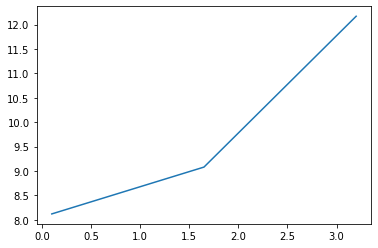

In [37]:
plt.plot(factors,fits)

In [188]:
factor = factors[np.argmin(fits)]

eps = kmodes[1]/(factor)
ksq[0,0,0] = eps**2
pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(boundary/np.pi)


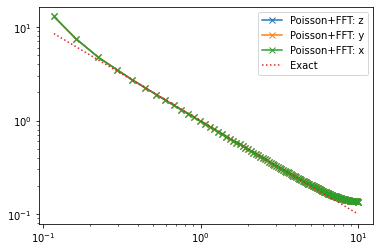

In [189]:
plt.loglog(rs[mid:],-pot[mid,mid,mid:],'x-',label='Poisson+FFT: z')
plt.loglog(rs[mid:],-pot[mid,mid:,mid],'x-',label='Poisson+FFT: y')
plt.loglog(rs[mid:],-pot[mid:,mid,mid],'x-',label='Poisson+FFT: x')
plt.loglog(rs[mid:],1/rs[mid:],':',label='Exact')
plt.legend()
plt.show()

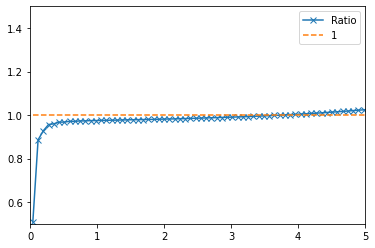

In [190]:
plt.plot(x[mid:],-pot[mid,mid,mid:]*x[mid:],'x-',label='Ratio')
plt.plot(x[mid:],x[mid:]/x[mid:],'--',label='1')
#plt.xscale('log')
plt.ylim(0.5,1.5)
plt.xlim(0,boundary/2)
plt.legend()
plt.show()

## Conclusions:

Not so bad, we get a sub 10% precision. It all comes from the $k^2=0$ term.

Now, let me check that:
0) It also works for other potential-density pairs
1) we can do this axis, by axis
2) I can load parts from a file as we go.
3) That way I can use larger grids.

## Other potential density pairs

Use this link: https://www.astro.utu.fi/~cflynn/galdyn/lecture4.html

### Homogenous sphere

In [208]:
NN = 256
mid = int((NN-1)/2+1)
print(f"{mid=}")

boundary=10.0

x = np.linspace(-boundary,boundary,NN)
step = (x[1]-x[0])

rs = np.sqrt(x**2 + step**2 + step**2)


kmodes = np.fft.fftfreq(NN)

rho0 = 1.0


print(f"{step=}")


xx,yy,zz = np.meshgrid(x,x,x)
kx,ky,kz = np.meshgrid(kmodes,kmodes,kmodes)

ksq = kx**2+ky**2+kz**2


rho = 0.0*kx

rsq = xx**2+yy**2+zz**2
mask = rsq<4.0
N = np.sum(mask*1)
print(N)
rho[mask] = 1.0/N

mid=128
step=0.07843137254901933
69264


In [209]:
factor = factors[np.argmin(fits)]

eps = kmodes[1]/(factor)
ksq[0,0,0] = eps**2
pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(boundary/np.pi)


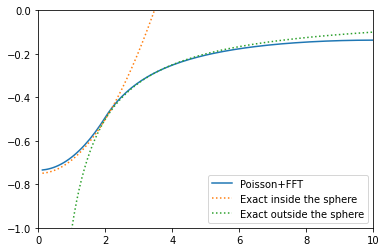

In [237]:
plt.plot(rs[mid:],pot[mid,mid,mid:],label="Poisson+FFT")
plt.plot(rs[mid:],-(3.0*4.0-rs[mid:]**2)/(2.0*8.0),':',label="Exact inside the sphere")
plt.plot(rs[mid:],-1/rs[mid:],':',label="Exact outside the sphere")
plt.xlim(0,10)
plt.ylim(-1,0)
plt.legend()
plt.show()

### Isothermal sphere

In [279]:
NN = 256
mid = int((NN-1)/2+1)
print(f"{mid=}")

boundary=10.0

x = np.linspace(-boundary,boundary,NN)
step = (x[1]-x[0])

rs = np.sqrt(x**2 + step**2 + step**2)


kmodes = np.fft.fftfreq(NN)

rho0 = 1.0


print(f"{step=}")


xx,yy,zz = np.meshgrid(x,x,x)
kx,ky,kz = np.meshgrid(kmodes,kmodes,kmodes)

ksq = kx**2+ky**2+kz**2


rho = 0.0*kx

rsq = xx**2+yy**2+zz**2
a=0.5
rho = 1.0/(rsq/a**2)
rhosum = np.sum(rho)

mid=128
step=0.07843137254901933


In [280]:
factor = factors[np.argmin(fits)]

eps = kmodes[1]/(factor)
ksq[0,0,0] = eps**2
pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(boundary/np.pi)


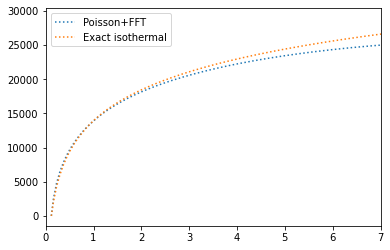

In [281]:
theory  = 4.0*np.pi*a**2*np.log(rs[mid:]/a)/step**3
theory0 = 4.0*np.pi*a**2*np.log(rs[mid] /a)/step**3

plt.plot(rs[mid:],pot[mid,mid,mid:]-pot[mid,mid,mid],':',label="Poisson+FFT")
plt.plot(rs[mid:],theory-theory0,':',label="Exact isothermal")
plt.xlim(0,7)
plt.legend()
plt.show()

### Let's try axisymmetric Miyamoto-Nagai

In [312]:
NN = 256
mid = int((NN-1)/2+1)
print(f"{mid=}")

boundary=10.0

x = np.linspace(-boundary,boundary,NN)
step = (x[1]-x[0])

rs = np.sqrt(x**2 + step**2 + step**2)


kmodes = np.fft.fftfreq(NN)

rho0 = 1.0


print(f"{step=}")


xx,yy,zz = np.meshgrid(x,x,x)
kx,ky,kz = np.meshgrid(kmodes,kmodes,kmodes)

ksq = kx**2+ky**2+kz**2

Rsq = xx**2+yy**2

a = 2.0
b = 0.3

rho = b**2/(4.0*np.pi)*(a*Rsq + (3.0*np.sqrt(zz**2+b**2)+a)*(np.sqrt(zz**2+b**2)+a)**2)/(Rsq + (np.sqrt(zz**2+b**2)+a)**2)**(2.5)/(np.sqrt(zz**2+b**2)**3)


mid=128
step=0.07843137254901933


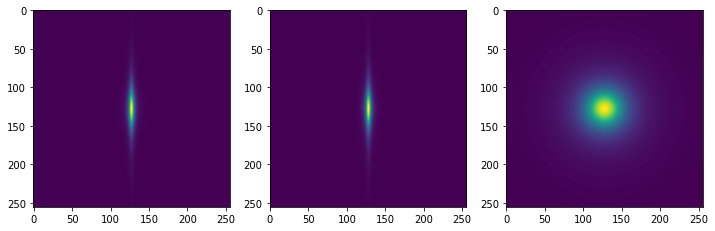

In [313]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(rho[mid])
plt.subplot(1,3,2)
plt.imshow(rho[:,mid,:])
plt.subplot(1,3,3)
plt.imshow(rho[:,:,mid])
plt.show()

In [333]:
factor = factors[np.argmin(fits)]

eps = kmodes[1]/(factor)
ksq[0,0,0] = eps**2
pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(boundary/np.pi)

theory = -1.0/np.sqrt(Rsq+(np.sqrt(zz**2+b**2)+a)**2)/step**3

In [327]:
theory_x = -1.0/np.sqrt(rs**2+(np.sqrt(step**2+b**2)+a)**2)/step**3
theory_y = -1.0/np.sqrt(rs**2+(np.sqrt(step**2+b**2)+a)**2)/step**3
theory_z = -1.0/np.sqrt(step**2+(np.sqrt(rs**2+b**2)+a)**2)/step**3

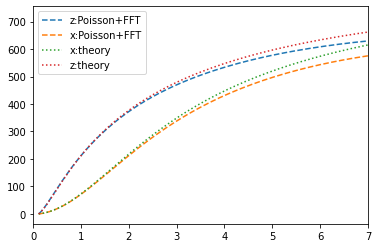

In [330]:
plt.plot(rs[mid:],pot[mid,mid,mid:]-pot[mid,mid,mid],'--',label="z:Poisson+FFT")
#plt.plot(rs[mid:],pot[mid,mid:,mid]-pot[mid,mid,mid],':',label="y:Poisson+FFT")
plt.plot(rs[mid:],pot[mid:,mid,mid]-pot[mid,mid,mid],'--',label="x:Poisson+FFT")

plt.plot(rs[mid:],theory_x[mid:]-theory_x[mid],':',label="x:theory")
#plt.plot(rs[mid:],theory_y[mid:]-theory_y[mid],':',label="y:theory")
plt.plot(rs[mid:],theory_z[mid:]-theory_z[mid],':',label="z:theory")

plt.xlim(0,7)
plt.legend()
plt.show()

<ipython-input-350-4e0e8b0a9ead>:6: RuntimeWarning: divide by zero encountered in true_divide
  pos = ax3.imshow((pot[minr:maxr,minr:maxr,mid]-pot[mid,mid,mid])/(theory[minr:maxr,minr:maxr,mid]-theory[mid,mid,mid]))
<ipython-input-350-4e0e8b0a9ead>:6: RuntimeWarning: invalid value encountered in true_divide
  pos = ax3.imshow((pot[minr:maxr,minr:maxr,mid]-pot[mid,mid,mid])/(theory[minr:maxr,minr:maxr,mid]-theory[mid,mid,mid]))


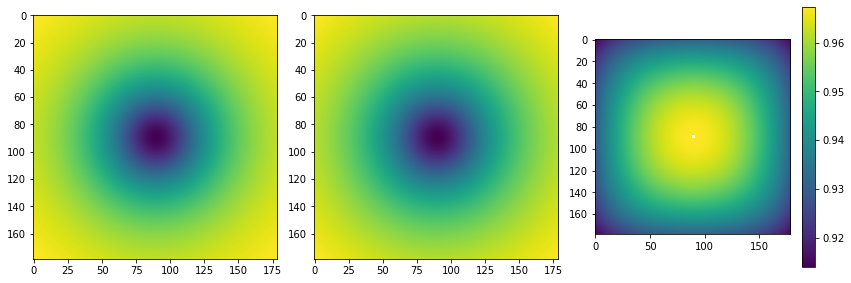

In [350]:
minr = int(0.3*mid)
maxr = int(1.7*mid)
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 4), ncols=3)
ax1.imshow(pot[minr:maxr,minr:maxr,mid]-pot[mid,mid,mid])
ax2.imshow(theory[minr:maxr,minr:maxr,mid]-theory[mid,mid,mid])
pos = ax3.imshow((pot[minr:maxr,minr:maxr,mid]-pot[mid,mid,mid])/(theory[minr:maxr,minr:maxr,mid]-theory[mid,mid,mid]))

fig.colorbar(pos, ax=ax3)

fig.tight_layout()
plt.show()

### The fiducial volume is roughly

In [354]:
((maxr-minr)/NN)**3

0.3418528437614441

### Conclusion: this seems decent...

## Now for the partial processing

In [383]:
NN = 256
mid = int((NN-1)/2+1)
print(f"{mid=}")

boundary=10.0

x = np.linspace(-boundary,boundary,NN)
step = (x[1]-x[0])

rs = np.sqrt(x**2 + step**2 + step**2)

kmodes = np.fft.fftfreq(NN)

rho0 = 1.0

print(f"{step=}")

xx,yy,zz = np.meshgrid(x,x,x)
kx,ky,kz = np.meshgrid(kmodes,kmodes,kmodes)

ksq = kx**2+ky**2+kz**2

Rsq = xx**2+yy**2

a = 2.0
b = 0.3

rho = b**2/(4.0*np.pi)*(a*Rsq + (3.0*np.sqrt(zz**2+b**2)+a)*(np.sqrt(zz**2+b**2)+a)**2)/(Rsq + (np.sqrt(zz**2+b**2)+a)**2)**(2.5)/(np.sqrt(zz**2+b**2)**3)


mid=128
step=0.07843137254901933


In [389]:
%%timeit

factor = factors[np.argmin(fits)]

eps = kmodes[1]/(factor)
ksq[0,0,0] = eps**2

rho_1 = fft.fft(rho,axis=0,workers=8)
rho_2 = fft.fft(rho_1,axis=1,workers=8)
rho_1 = fft.fft(rho_2,axis=2,workers=8)

rho_2 = rho_1/ksq

rho_1 = fft.ifft(rho_2,axis=2,workers=8)
rho_2 = fft.ifft(rho_1,axis=1,workers=8)
phi = -4.0*np.pi*np.real(fft.ifft(rho_2,axis=0,workers=8))/(boundary/np.pi)

#pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(boundary/np.pi)

#theory = -1.0/np.sqrt(Rsq+(np.sqrt(zz**2+b**2)+a)**2)/step**3

1.09 s ± 50.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [390]:
%%timeit

factor = factors[np.argmin(fits)]

eps = kmodes[1]/(factor)
ksq[0,0,0] = eps**2

rho_1 = fft.fft2(rho,axes=(0,1),workers=8)
rho_2 = fft.fft(rho_1,axis=2,workers=8)

rho_1 = rho_2/ksq

rho_2 = fft.ifft2(rho_1,axes=(0,1),workers=8)
phi = -4.0*np.pi*np.real(fft.ifft(rho_2,axis=2,workers=8))/(boundary/np.pi)

#pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(boundary/np.pi)

#theory = -1.0/np.sqrt(Rsq+(np.sqrt(zz**2+b**2)+a)**2)/step**3

1.02 s ± 41.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [391]:
%%timeit

factor = factors[np.argmin(fits)]

eps = kmodes[1]/(factor)
ksq[0,0,0] = eps**2

pot = - 4.0*np.pi*np.real(fft.ifftn(fft.fftn(rho,workers=8)/ksq,workers=8))/(boundary/np.pi)

#theory = -1.0/np.sqrt(Rsq+(np.sqrt(zz**2+b**2)+a)**2)/step**3

822 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


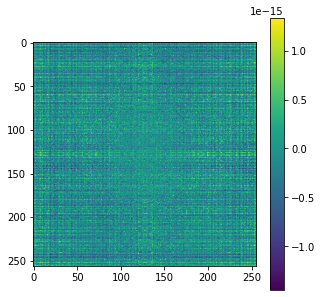

In [378]:
fig, ax1 = plt.subplots(figsize=(5,5))
g = ax1.imshow(phi[mid]/pot[mid]-1)
fig.colorbar(g,ax=ax1)

## Load and reload with different slicing...

The idea is to keep the whole array separate in 8 pieces along one axis. Then do the FFTs in the full directions. Save into a file and then load with slicing in the other direction. Finish the FFTs that way.

In [1]:
import h5py
from sys import getsizeof
import tqdm
import scipy as sp
from scipy import fft
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def prepare_delta(filename, NN, rho0):
    with h5py.File(filename,'w') as F:
        dset = F.create_dataset('d1',(NN,NN,NN), dtype='complex')
        mid = NN//2
        ## construct the density profile by scanning over axis 0

        dset[mid,mid,mid]       = rho0/8.0
        dset[mid-1,mid,mid]     = rho0/8.0
        dset[mid,mid-1,mid]     = rho0/8.0
        dset[mid,mid,mid-1]     = rho0/8.0
        dset[mid-1,mid-1,mid]   = rho0/8.0
        dset[mid,mid-1,mid-1]   = rho0/8.0
        dset[mid-1,mid,mid-1]   = rho0/8.0
        dset[mid-1,mid-1,mid-1] = rho0/8.0

In [3]:
def get_potential(filename, NN, slices, kmodes, factor):
    
    nn = NN//slices
    eps = kmodes[1]/factor
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']

        ## do the fft2 on axes (1,2), scanning over axis 0

        for ii in range(slices):
            a = dset[ii*nn:(ii+1)*nn,:,:]
            dset[ii*nn:(ii+1)*nn] = fft.fft2(a,axes=(1,2),workers=8)


        ## do the fft on axes 0, scanning over axis 1

        for ii in range(slices):
            a = dset[:,ii*nn:(ii+1)*nn,:]
            dset[:,ii*nn:(ii+1)*nn] = fft.fft(a,axis=0,workers=8)


        ## divide by ksq scanning over axis 0

        for ii in range(slices):
            ksub = kmodes[ii*nn:(ii+1)*nn]
            kx,ky,kz = np.meshgrid(ksub,kmodes,kmodes,indexing='ij')
            ksq = np.copy(kx**2+ky**2+kz**2)
            if ksq[0,0,0] == 0:
                ksq[0,0,0] = eps**2
            del kx,ky,kz
            a = dset[ii*nn:(ii+1)*nn,:,:]
            dset[ii*nn:(ii+1)*nn] = a/ksq


        ## do the inverse fft2 on axes (1,2), scanning over axis 0

        for ii in range(slices):
            a = dset[ii*nn:(ii+1)*nn,:,:]
            dset[ii*nn:(ii+1)*nn] = fft.ifft2(a,axes=(1,2),workers=8)


        ## do the inverse fft on axis (0), scanning over axis 1

        for ii in range(slices):
            a = dset[:,ii*nn:(ii+1)*nn,:]
            dset[:,ii*nn:(ii+1)*nn] =  fft.ifft(a,axis=0,workers=8)/np.pi

        ## The factor of pi comes from 4*pi/(2*pi)^2
    


In [4]:
def get_potential_v2(filename, NN, slices, kmodes, factor):
    
    nn = NN//slices
    eps = kmodes[1]/factor
    
    with h5py.File(filename,'r+') as F:
        dset = F['d1']

        ## do the fft2 on axes (1,2), scanning over axis 0

        for ii in range(slices):
            dset[ii*nn:(ii+1)*nn] = fft.fft2(dset[ii*nn:(ii+1)*nn,:,:],axes=(1,2),workers=8)


        ## do the fft on axes 0, scanning over axis 1

        for ii in range(slices):
            dset[:,ii*nn:(ii+1)*nn] = fft.fft(dset[:,ii*nn:(ii+1)*nn,:],axis=0,workers=8)


        ## divide by ksq scanning over axis 0

        for ii in range(slices):
            ksub = kmodes[ii*nn:(ii+1)*nn]
            kx,ky,kz = np.meshgrid(ksub,kmodes,kmodes,indexing='ij')
            ksq = np.copy(kx**2+ky**2+kz**2)
            if ksq[0,0,0] == 0:
                ksq[0,0,0] = eps**2
            del kx,ky,kz
            dset[ii*nn:(ii+1)*nn] = dset[ii*nn:(ii+1)*nn,:,:]/ksq
        del ksq

        ## do the inverse fft2 on axes (1,2), scanning over axis 0

        for ii in range(slices):
            dset[ii*nn:(ii+1)*nn] = fft.ifft2(dset[ii*nn:(ii+1)*nn,:,:],axes=(1,2),workers=8)


        ## do the inverse fft on axis (0), scanning over axis 1

        for ii in range(slices):
            dset[:,ii*nn:(ii+1)*nn] =  fft.ifft(dset[:,ii*nn:(ii+1)*nn,:],axis=0,workers=8)/np.pi

        ## The factor of pi comes from 4*pi/(2*pi)^2

In [5]:
def get_zaxis(filename,mid):
    with h5py.File(filename,'r+') as F:
        dset = F['d1']
        myslice = np.copy(dset[mid,mid,mid:])
        return myslice

In [6]:
# Universal variables

boundary=10.0

In [7]:
%%time

NN = 256
mid_256 = NN//2

x_256 = np.linspace(-boundary,boundary,NN)
step_256   = (x_256[1]-x_256[0])
rs_256 = np.sqrt(x_256**2+step_256**2+step_256**2)
kmodes_256 = np.fft.fftfreq(NN,d=step_256)
rho0_256 = 1/step_256**3

results_256 = []
factors_256 = np.linspace(2.7,3.1,17)

for factor in tqdm.tqdm(factors_256):

    prepare_delta('testfile.h5', NN, rho0_256)
    get_potential('testfile.h5', NN, slices=8, kmodes=kmodes_256, factor=factor)
    xaxis = get_zaxis('testfile.h5',mid_256)
    results_256.append(xaxis)

100%|██████████| 17/17 [00:32<00:00,  1.94s/it]

CPU times: user 1min 15s, sys: 31.4 s, total: 1min 47s
Wall time: 33 s


In [8]:
%%time

NN = 256
mid_256 = NN//2

x_256 = np.linspace(-boundary,boundary,NN)
step_256   = (x_256[1]-x_256[0])
rs_256 = np.sqrt(x_256**2+step_256**2+step_256**2)
kmodes_256 = np.fft.fftfreq(NN,d=step_256)
rho0_256 = 1/step_256**3

results_256_v2 = []
factors_256 = np.linspace(2.7,3.1,17)

for factor in tqdm.tqdm(factors_256):

    prepare_delta('testfile.h5', NN, rho0_256)
    get_potential_v2('testfile.h5', NN, slices=8, kmodes=kmodes_256, factor=factor)
    xaxis = get_zaxis('testfile.h5',mid_256)
    results_256_v2.append(xaxis)

100%|██████████| 17/17 [00:34<00:00,  2.06s/it]

CPU times: user 1min 15s, sys: 49.7 s, total: 2min 5s
Wall time: 35 s


In [9]:
%%time

NN = 512
mid_512 = NN//2

x_512 = np.linspace(-boundary,boundary,NN)
step_512   = (x_512[1]-x_512[0])
rs_512 = np.sqrt(x_512**2+step_512**2+step_512**2)
kmodes_512 = np.fft.fftfreq(NN,d=step_512)
rho0_512 = 1/step_512**3

results_512 = []
factors_512 = np.linspace(2.7,3.1,17)

for factor in tqdm.tqdm(factors_512):

    prepare_delta('testfile.h5', NN, rho0_512)
    get_potential('testfile.h5', NN, slices=8, kmodes=kmodes_512, factor=factor)
    xaxis = get_zaxis('testfile.h5',mid_512)
    results_512.append(xaxis)

100%|██████████| 17/17 [04:58<00:00, 17.55s/it]

CPU times: user 11min 34s, sys: 6min 33s, total: 18min 8s
Wall time: 4min 58s


In [10]:
%%time

NN = 512
mid_512 = NN//2

x_512 = np.linspace(-boundary,boundary,NN)
step_512   = (x_512[1]-x_512[0])
rs_512 = np.sqrt(x_512**2+step_512**2+step_512**2)
kmodes_512 = np.fft.fftfreq(NN,d=step_512)
rho0_512 = 1/step_512**3

results_512_v2 = []
factors_512 = np.linspace(2.7,3.1,17)

for factor in tqdm.tqdm(factors_512):

    prepare_delta('testfile.h5', NN, rho0_512)
    get_potential_v2('testfile.h5', NN, slices=8, kmodes=kmodes_512, factor=factor)
    xaxis = get_zaxis('testfile.h5',mid_512)
    results_512_v2.append(xaxis)

100%|██████████| 17/17 [05:00<00:00, 17.68s/it]

CPU times: user 11min 41s, sys: 6min 31s, total: 18min 13s
Wall time: 5min


In [11]:
%%time

NN = 1024
mid_1024 = NN//2

x_1024 = np.linspace(-boundary,boundary,NN)
step_1024   = (x_1024[1]-x_1024[0])
rs_1024 = np.sqrt(x_1024**2+step_1024**2+step_1024**2)
kmodes_1024 = np.fft.fftfreq(NN,d=step_1024)
rho0_1024 = 1/step_1024**3

results_1024 = []
factors_1024 = np.linspace(2.7,3.1,9)

for factor in tqdm.tqdm(factors_1024):

    prepare_delta('testfile.h5', NN, rho0_1024)
    get_potential('testfile.h5', NN, slices=8, kmodes=kmodes_1024, factor=factor)
    xaxis = get_zaxis('testfile.h5',mid_1024)
    results_1024.append(xaxis)

100%|██████████| 9/9 [33:59<00:00, 226.57s/it]

CPU times: user 1h 16min 36s, sys: 32min 54s, total: 1h 49min 31s
Wall time: 33min 59s


In [ ]:
%%time

NN = 2048
mid_2048 = NN//2

x_2048 = np.linspace(-boundary,boundary,NN)
step_2048   = (x_2048[1]-x_2048[0])
rs_2048 = np.sqrt(x_2048**2+step_2048**2+step_2048**2)
kmodes_2048 = np.fft.fftfreq(NN,d=step_2048)
rho0_2048 = 1/step_2048**3

results_2048 = []
factors_2048 = [3.0]

for factor in tqdm.tqdm(factors_2048):

    prepare_delta('testfile.h5', NN, rho0_2048)
    get_potential('testfile.h5', NN, slices=32, kmodes=kmodes_2048, factor=factor)
    xaxis = get_zaxis('testfile.h5',mid_2048)
    results_2048.append(xaxis)

  0%|          | 0/1 [00:00<?, ?it/s]

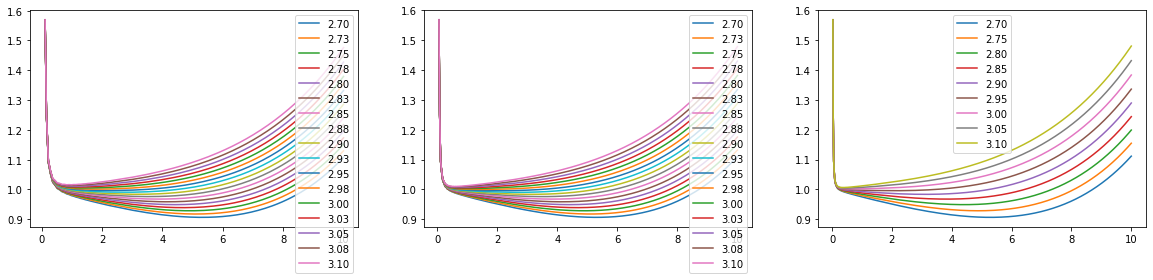

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(20,4),ncols=3)

for data,factor in zip(results_256,factors_256):
    ax1.plot(rs_256[mid_256:],np.real(data)*rs_256[mid_256:],'-',label=f"{factor:.2f}")
ax1.legend()

for data,factor in zip(results_512,factors_512):
    ax2.plot(rs_512[mid_512:],np.real(data)*rs_512[mid_512:],'-',label=f"{factor:.2f}")
ax2.legend()

for data,factor in zip(results_1024,factors_1024):
    ax3.plot(rs_1024[mid_1024:],np.real(data)*rs_1024[mid_1024:],'-',label=f"{factor:.2f}")
ax3.legend()


plt.show()

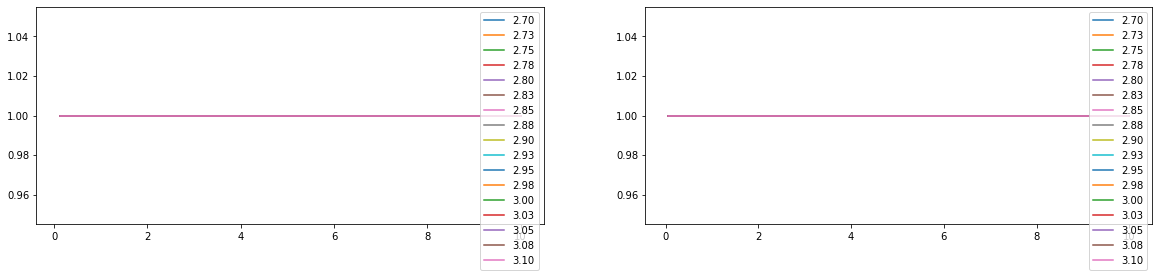

In [13]:
fig, (ax1,ax2) = plt.subplots(figsize=(20,4),ncols=2)

for data1,data2,factor in zip(results_256,results_256_v2,factors_256):
    ax1.plot(rs_256[mid_256:],np.real(data1)/np.real(data2),'-',label=f"{factor:.2f}")
ax1.legend()

for data1,data2,factor in zip(results_512,results_512_v2,factors_512):
    ax2.plot(rs_512[mid_512:],np.real(data1)/np.real(data2),'-',label=f"{factor:.2f}")
ax2.legend()

In [14]:
### Which is the best choice?

x_256 = np.linspace(-boundary,boundary,256)
x_256 = x_256[128:]
mask_256_7 = (x_256>0) & (x_256 <= 7)
mask_256_5 = (x_256>0) & (x_256 <= 5)

residues_256_all = np.sqrt(np.sum((  1.0-rs_256[mid_256:]*np.real(results_256))**2,                axis=1))
residues_256_7   = np.sqrt(np.sum((((1.0-rs_256[mid_256:]*np.real(results_256)))**2)[:,mask_256_7],axis=1))
residues_256_5   = np.sqrt(np.sum((((1.0-rs_256[mid_256:]*np.real(results_256)))**2)[:,mask_256_5],axis=1))

x_512 = np.linspace(-boundary,boundary,512)
x_512 = x_512[256:]
mask_512_7 = (x_512>0) & (x_512 <= 7)
mask_512_5 = (x_512>0) & (x_512 <= 5)

residues_512_all = np.sqrt(np.sum((  1.0-rs_512[mid_512:]*np.real(results_512))**2,                axis=1))
residues_512_7   = np.sqrt(np.sum((((1.0-rs_512[mid_512:]*np.real(results_512)))**2)[:,mask_512_7],axis=1))
residues_512_5   = np.sqrt(np.sum((((1.0-rs_512[mid_512:]*np.real(results_512)))**2)[:,mask_512_5],axis=1))

x_1024 = np.linspace(-boundary,boundary,1024)
x_1024 = x_1024[512:]
mask_1024_7 = (x_1024>0) & (x_1024 <= 7)
mask_1024_5 = (x_1024>0) & (x_1024 <= 5)

residues_1024_all = np.sqrt(np.sum((  1.0-rs_1024[mid_1024:]*np.real(results_1024))**2,                axis=1))
residues_1024_7   = np.sqrt(np.sum((((1.0-rs_1024[mid_1024:]*np.real(results_1024)))**2)[:,mask_1024_7],axis=1))
residues_1024_5   = np.sqrt(np.sum((((1.0-rs_1024[mid_1024:]*np.real(results_1024)))**2)[:,mask_1024_5],axis=1))

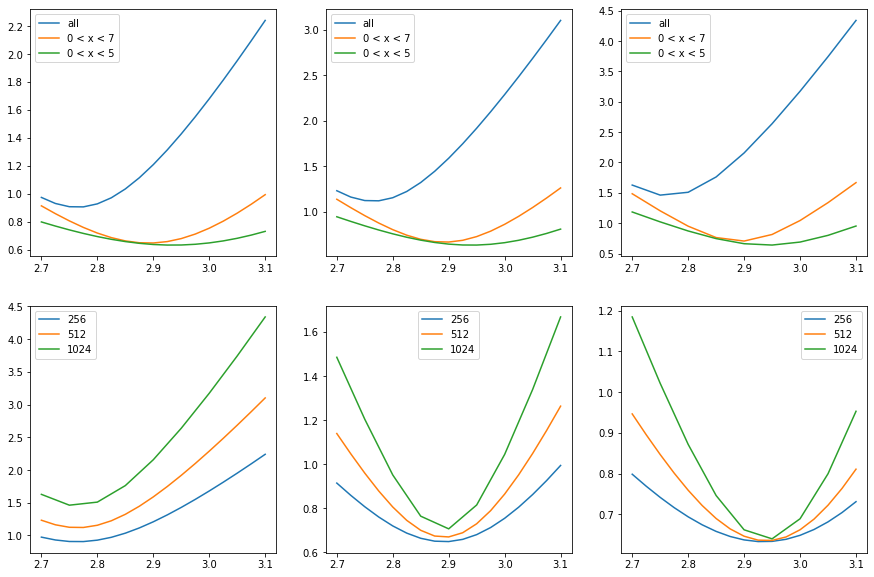

In [15]:
### Which is the best choice?
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)
plt.plot(factors_256,residues_256_all,label='all')
plt.plot(factors_256,residues_256_7,label='0 < x < 7')
plt.plot(factors_256,residues_256_5,label='0 < x < 5')
plt.legend()
plt.subplot(2,3,2)
plt.plot(factors_512,residues_512_all,label='all')
plt.plot(factors_512,residues_512_7,label='0 < x < 7')
plt.plot(factors_512,residues_512_5,label='0 < x < 5')
plt.legend()
plt.subplot(2,3,3)
plt.plot(factors_1024,residues_1024_all,label='all')
plt.plot(factors_1024,residues_1024_7,label='0 < x < 7')
plt.plot(factors_1024,residues_1024_5,label='0 < x < 5')
plt.legend()

plt.subplot(2,3,4)
plt.plot(factors_256,residues_256_all,label='256')
plt.plot(factors_512,residues_512_all,label='512')
plt.plot(factors_1024,residues_1024_all,label='1024')

plt.legend()
plt.subplot(2,3,5)

plt.plot(factors_256,residues_256_7,label='256')
plt.plot(factors_512,residues_512_7,label='512')
plt.plot(factors_1024,residues_1024_7,label='1024')

plt.legend()
plt.subplot(2,3,6)
plt.plot(factors_256,residues_256_5,label='256')
plt.plot(factors_512,residues_512_5,label='512')
plt.plot(factors_1024,residues_1024_5,label='1024')
plt.legend()

plt.show()